In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


In [13]:
import pandas as pd

data = pd.read_csv(
    "ml-100k/u.data",
    sep = "\t",
    names = ["user", "item", "rating", "timestamp"]
)

data.head()

,user,item,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [14]:
print("数据条数：", len(data))
# 这里是nunique()
print("用户数量：", data["user"].nunique())
print("物品数量：", data["item"].nunique())

数据条数： 100000
用户数量： 943
物品数量： 1682


In [15]:
data["user"] -= 1
data["item"] -= 1

In [16]:
data = data.sort_values(by=["user", "timestamp"])
data


,user,item,rating,timestamp
59972,0,167,5,874965478
92487,0,171,5,874965478
74577,0,164,5,874965518
48214,0,155,4,874965556
15764,0,195,5,874965677
...,...,...,...,...
93377,942,448,1,888693158
94914,942,228,2,888693158
95003,942,229,1,888693158
95291,942,227,3,888693158


In [17]:
# 我们需要给每个用户学习一个向量，给每个物品学习一个向量
# 所以需要给两个东西进行embedding操作，这种操作本质是一个查表操作
# 由于nn.embedding里面的矩阵索引从0开始，所以我们要把用户和物品的序号也从0开始

In [ ]:
train_list = []
test_list = []

# groupby按某一列分组，得到一个小的DataFrame
# {
#   0: DataFrame(两行)
#   1: DataFrame(两行)
# }
for user, group in data.groupby("user"):
    group = group.sort_values("timestamp")
    
    # 这个是单行
    test_interaction = group.iloc[-1]     # 最后一个给测试
    # 这个是DataFrame
    train_interactions = group.iloc[:-1]  # 其他给训练
    
    test_list.append(test_interaction)
    train_list.append(train_interactions)

# 所以拼接方式不同
train_data = pd.concat(train_list)
test_data = pd.DataFrame(test_list)

In [19]:
train_data

,user,item,rating,timestamp
59972,0,167,5,874965478
92487,0,171,5,874965478
74577,0,164,5,874965518
48214,0,155,4,874965556
22971,0,165,5,874965677
...,...,...,...,...
92536,942,226,1,888693158
93377,942,448,1,888693158
94914,942,228,2,888693158
95003,942,229,1,888693158


In [20]:
test_data

,user,item,rating,timestamp
19699,0,101,2,889751736
7519,1,280,3,888980240
37188,2,180,4,889237482
48826,3,10,4,892004520
32177,4,394,2,879198898
...,...,...,...,...
94676,938,253,3,880262319
82942,939,315,4,889480582
98516,940,0,5,875049144
88898,941,661,4,891283517


In [ ]:
print("user 最小值：", data["user"].min())
print("user 最大值：", data["user"].max())

In [ ]:
print("item 最小值：", data["item"].min())
print("item 最大值：", data["item"].max())

In [ ]:
# 他们的下标都没有从0开始，超出索引范围所以要减1
data["user"] -= 1
data["item"] -= 1

In [ ]:
print("user 最小值：", data["user"].min())
print("user 最大值：", data["user"].max())

In [ ]:
print("item 最小值：", data["item"].min())
print("item 最大值：", data["item"].max())

In [ ]:
num_items = data["item"].nunique()
num_items

In [21]:
# 推荐系统必须把数据变成结构化形式，上面只是记录了交互，需要构建用户的交互矩阵
# 比如我们需要知道每个用户看过什么电影，用来构建负样本的采样
# 从用户行为日志构建用户兴趣集合
user_pos_items = {}

for user, item in zip(train_data["user"], train_data["item"]):
    if user not in user_pos_items:
        user_pos_items[user] = set()
    user_pos_items[user].add(item)

In [ ]:
print("用户数量：", len(user_pos_items))
print("用户0看过的电影数量：", len(user_pos_items[0]))
# 因为set是一个无序的集合，所以切片要变成list
print("用户0看过的前十个电影：", list(user_pos_items[0])[:10])

In [23]:
num_users = train_data["user"].nunique()
num_items = train_data["item"].nunique()
num_items, num_users

(1679, 943)

In [24]:
# 从user_pos_items生成负样本，也就是变成(u, i, j)
# u是用户，i是他看过的，j是他没看过的
import random
import torch

num_items = data["item"].nunique()

def generate_train_data(user_pos_items, num_items):
    users = []
    pos_items = []
    neg_items = []

    for user in user_pos_items:
        for pos_item in user_pos_items[user]:

            # 随机采负样本
            # 这个和range还不一样，这个是左闭右闭的
            neg_item = random.randint(0, num_items - 1)

            # 如果采到了正样本，重新采
            while neg_item in user_pos_items[user]:
                neg_item = random.randint(0, num_items - 1)

            users.append(user)
            pos_items.append(pos_item)
            neg_items.append(neg_item)

    # PyTorch的tensor有数据类型，LongTensor是int64 tensor
    return torch.LongTensor(users), torch.LongTensor(pos_items), torch.LongTensor(neg_items)
            

In [25]:
users, pos_items, neg_items = generate_train_data(user_pos_items, num_items)

# 100000条是给每个用户的每个看过的电影，搭配一个负样本
print("训练样本数量:", len(users))
print("示例前三个样本:")
for i in range(3):
    print(users[i].item(), pos_items[i].item(), neg_items[i].item())

训练样本数量: 99057
示例前三个样本:
0 0 1376
0 1 655
0 2 1222


In [26]:
import torch
import torch.nn as nn

class MF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim = 64):
        super().__init__()

        # embedding矩阵的维度是[943, 64], [1682, 64]
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

    def forward(self, users, items):
        # 传入的是LongTensor，根据embedding矩阵查表
        # 返回[100000, 64]，就是给每个样本找他的向量
        user_vec = self.user_embedding(users)
        item_vec = self.item_embedding(items)
        # 这里不是矩阵乘法，这里是逐元素乘法，返回的依旧是[100000, 64]
        # user_vec[0] = [a1,a2,...,a64]
        # item_vec[0] = [b1,b2,...,b64]
        # [a1b1, a2b2, ..., a64b64]
        # 然后按列降维，变成[100000]，就表示每一个样本对这个物品的评分
        scores = (user_vec * item_vec).sum(dim=1)

        return scores

In [27]:
num_users = data["user"].nunique()
num_items = data["item"].nunique()
print(num_users, num_items)

943 1682


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [29]:
model = MF(num_users, num_items, embedding_dim = 64).to(device)

In [30]:
# BPR损失
def bpr_loss(pos_scores, neg_scores):
    return -torch.mean(torch.log(torch.sigmoid(pos_scores - neg_scores)))

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [32]:
batch_size = 2048
loss_list = []

for epoch in range(500):

    users, pos_items, neg_items = generate_train_data(user_pos_items, num_items)

    users = users.to(device)
    pos_items = pos_items.to(device)
    neg_items = neg_items.to(device)

    model.train()

    epoch_loss = 0
    num_batches = len(users) // batch_size

    for i in range(num_batches):

        batch_users = users[i*batch_size:(i+1)*batch_size]
        batch_pos = pos_items[i*batch_size:(i+1)*batch_size]
        batch_neg = neg_items[i*batch_size:(i+1)*batch_size]

        pos_scores = model(batch_users, batch_pos)
        neg_scores = model(batch_users, batch_neg)

        loss = bpr_loss(pos_scores, neg_scores)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= num_batches
    loss_list.append(epoch_loss)

    print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")


Epoch 0, Loss: 4.4567
Epoch 1, Loss: 3.8707
Epoch 2, Loss: 3.4160
Epoch 3, Loss: 2.9949
Epoch 4, Loss: 2.5440
Epoch 5, Loss: 2.1248
Epoch 6, Loss: 1.6931
Epoch 7, Loss: 1.3508
Epoch 8, Loss: 1.0475
Epoch 9, Loss: 0.8573
Epoch 10, Loss: 0.7073
Epoch 11, Loss: 0.6085
Epoch 12, Loss: 0.5215
Epoch 13, Loss: 0.4725
Epoch 14, Loss: 0.4224
Epoch 15, Loss: 0.3877
Epoch 16, Loss: 0.3493
Epoch 17, Loss: 0.3197
Epoch 18, Loss: 0.2981
Epoch 19, Loss: 0.2765
Epoch 20, Loss: 0.2575
Epoch 21, Loss: 0.2373
Epoch 22, Loss: 0.2201
Epoch 23, Loss: 0.2099
Epoch 24, Loss: 0.1976
Epoch 25, Loss: 0.1879
Epoch 26, Loss: 0.1794
Epoch 27, Loss: 0.1679
Epoch 28, Loss: 0.1613
Epoch 29, Loss: 0.1568
Epoch 30, Loss: 0.1455
Epoch 31, Loss: 0.1425
Epoch 32, Loss: 0.1364
Epoch 33, Loss: 0.1288
Epoch 34, Loss: 0.1245
Epoch 35, Loss: 0.1223
Epoch 36, Loss: 0.1130
Epoch 37, Loss: 0.1117
Epoch 38, Loss: 0.1095
Epoch 39, Loss: 0.1070
Epoch 40, Loss: 0.1048
Epoch 41, Loss: 0.0996
Epoch 42, Loss: 0.0994
Epoch 43, Loss: 0.093

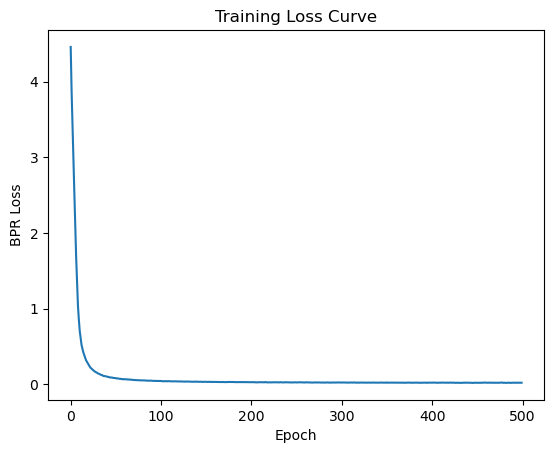

In [33]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(loss_list)
plt.xlabel("Epoch")
plt.ylabel("BPR Loss")
plt.title("Training Loss Curve")
plt.show()

In [34]:
def recall_at_k(model, train_dict, test_data, num_items, k=10):
    model.eval()
    hit = 0

    with torch.no_grad():
        for _, row in test_data.iterrows():
            user = int(row["user"])
            true_item = int(row["item"])

            user_tensor = torch.LongTensor([user]).to(device)

            all_items = torch.arange(num_items).to(device)

            scores = model(
                user_tensor.repeat(num_items),
                all_items
            )

            # 去掉训练集中看过的物品
            train_items = train_dict[user]
            scores[list(train_items)] = -1e9

            topk = torch.topk(scores, k).indices.cpu().numpy()

            if true_item in topk:
                hit += 1

    return hit / len(test_data)


In [35]:
recall = recall_at_k(model, user_pos_items, test_data, num_items, k=10)
print("Recall@10:", recall)

Recall@10: 0.0975609756097561
